In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import lambertw
from scipy.optimize import curve_fit

In [21]:
S_0 = 1.0 # Assume the S(t) data is normalized to the initial concentration of S

## Rate law (uni-molecular, reversible, Haldane)

$\frac{dS}{dt} = - E~\frac{k_{cat}^+ S/K_S - k_{cat}^- P/K_P}{1 + S/K_S + P/K_P}$

## Definitions:

- $P(\infty) = \frac{S_0}{K_{eq}^{-1} + 1}$
- $k_{cat}^* \equiv \frac{k_{cat}^+ / K_S + k_{cat}^- / K_P}{1 / K_S - 1 / K_P}$
- $K_M^* \equiv \frac{1 + S(0) / K_S}{1 / K_S - 1 / K_P} - P(\infty)$
- $\omega \equiv \frac{P(\infty)}{K_M^*}$
- $\beta \equiv \frac{E ~ k_{cat}^*}{K_M^*}$

## Type 1 Solution:
$S(t) = P(\infty)\left(1 - \omega^{-1}~W_0\left(\omega \cdot e^{\omega} \cdot e^{-\beta t}\right)\right)$


## Rate law (bi-molecular, irreversible, random binding)

$\frac{dS}{dt} = - E~k_{cat}~\frac{(S_1(t)/K_{S,1})\cdot(S_2(t)/K_{S,2})}{1 + (S_1(t)/K_{S,1})\cdot(S_2(t)/K_{S,2})}$

## Definitions:

- $S(\infty) = 0$
- $K_M^* \equiv \sqrt{K_{S,1} \cdot K_{S,2}}$
- $\omega \equiv P(\infty) / K_M^*$
- $\beta \equiv \frac{E ~ k_{cat}}{K_M^*}$

## Type 2 Solution:
$P(t) = \frac{P(\infty)}{2 \omega}\left( \omega + \omega^{-1} + \beta t ~-~ \sqrt{ \left(\omega - \omega^{-1} - \beta t \right)^2 + 4} \right)$

## Rate law (bi-molecular, irreversible, generalized)

$\frac{dS}{dt} = - E~k_{cat}~\frac{S^2}{a + b S + S^2}$

## Definitions:

- $S(\infty) = 0$

## Solution (inverse, cannot be used for fitting):
$t = \frac{P(t) - b \ln{(1 - P(t)/P(\infty))} + a ((P(\infty) - P(t))^{-1} - P(\infty)^{-1})}{E \cdot k_{cat}}$



In [22]:
FORMS = ["michaelis_menten", "type1", "type2"]
COLORS = ["red", "green", "blue"]
FORM2COLOR = dict(zip(FORMS, COLORS))

def analytic_michaelis_menten(t, K_M) -> np.ndarray:
  return t / (t + K_M)

def analytic_type1(t, P_inf, omega, beta) -> np.ndarray:
  """Analytic solution for the uni-uni case."""
  return P_inf * (1.0 - lambertw(omega * np.exp(omega) * np.exp(-beta*t), k=0).real / omega)

def analytic_type2(t, P_inf, omega, beta) -> np.ndarray:
  """Analytic solution for the bi-bi."""
  return P_inf / (2.0 * omega) * (omega + 1.0/omega + beta*t - np.sqrt((omega - 1.0/omega - beta*t)**2 + 4.0))

def analytic(form) -> callable:
  if form == "michaelis_menten":
    return analytic_michaelis_menten
  elif form == "type1":
    return analytic_type1
  elif form == "type2":
    return analytic_type2
  else:
    raise KeyError("unknown form: " + form)

def analytic_bi_random_inverse(P, S_0, E, kcat, a, b):
  # solution for the ODE:
  # dS/dt = -E*kcat* S^2 / (a + b*S + S^2)
  # is:
  # t = (P - b ln(1 - P/S_0) + a * ( 1/(S_0 - P) - 1/S_0)) / (E*kcat)
  #
  return (P - b * np.log(1.0 - P/S_0) + a * ( 1.0/(S_0 - P) - 1.0/S_0)) / (E*kcat)

def fit_analytic(tdata, Sdata, form: str) -> np.ndarray:
  f = analytic(form)
  if form == "michaelis_menten":
    p0 = [1.0]
    bounds = ([1e-3], [1e3])
  elif form == "type1":
    p0 = [1.0, 1.0, 1.0]
    bounds = ([1e-3, 1e-3, 1e-3], [1e3, 1e3, 1e3])
  elif form == "type2":
    p0 = [1.0, 1.0, 1.0]
    bounds = ([1e-3, 1e-3, 1e-3], [1e3, 1e3, 1e3])
  else:
    raise KeyError("unknown form: " + form)

  popt, pcov = curve_fit(
      f=f,
      xdata=tdata,
      ydata=Sdata,
      p0=p0,
      bounds=bounds,
      full_output=False,
  )
  return popt

def simulate_enzyme_assay_uni(t_eval, S_0, E, kcat_plus, K_S, K_P, K_eq):
  """
  Simulates the time trajectory of an enzyme assay using ODE solver.

  Returns:
      Time points and corresponding substrate concentrations.
  """

  def dSdt(t, P, S_0, E, kcat_plus, kcat_minus, K_S, K_P):
    """Defines the differential equation for substrate concentration."""
    S = S_0 - P
    return E * (kcat_plus * (S / K_S) - kcat_minus * (P / K_P)) / (1.0 + (S / K_S) + (P / K_P))

  t_span = (0, max(t_eval))
  kcat_minus = kcat_plus * (K_P / K_S / K_eq)
  sol = solve_ivp(dSdt, t_span, [0.0], args=(S_0, E, kcat_plus, kcat_minus, K_S, K_P), t_eval=t_eval)
  return sol.y[0]

def simulate_enzyme_assay_bi(t_eval, S_0, E, kcat, K_S1, K_S2):
  """
  Simulates the time trajectory of an enzyme assay using ODE solver.

  Returns:
      Time points and corresponding substrate concentrations.
  """
  def dSdt(t, P, S_0, E, kcat, K_S1, K_S2):
    """Defines the differential equation for substrate concentration."""
    S = S_0 - P
    return E * kcat * (S/K_S1) * (S/K_S2) / (1 + (S/K_S1) * (S/K_S2))

  t_span = (0, max(t_eval))
  sol = solve_ivp(dSdt, t_span, [0.0], args=(S_0, E, kcat, K_S1, K_S2), t_eval=t_eval)
  return sol.y[0]

def simulate_enzyme_assay_bi_general(t_eval, S_0, E, kcat, a, b):
  """
  Simulates the time trajectory of an enzyme assay using ODE solver.

  Returns:
      Time points and corresponding substrate concentrations.
  """
  def dSdt(t, P, S_0, E, kcat, a, b):
    """Defines the differential equation for substrate concentration."""
    S = S_0 - P
    return E * kcat * S**2 / (a + b*S + S**2)

  t_span = (0, max(t_eval))
  sol = solve_ivp(dSdt, t_span, [0.0], args=(S_0, E, kcat, a, b), t_eval=t_eval)
  return sol.y[0]

(0.0, 1.0)

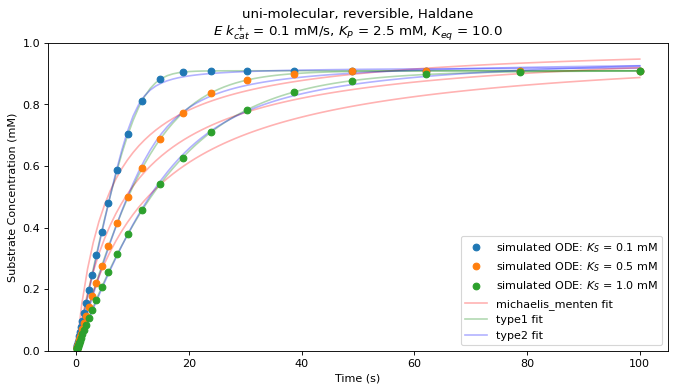

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=80)

E = 1.0  # mM
kcat_plus = 0.1  # 1/s
K_P = 2.5  # mM
K_eq = 10.0

t_eval = np.logspace(-1, 2, 30)
t_simulate = np.linspace(0, 100, 100)
for i, K_S in enumerate([0.1, 0.5, 1.0]): # mM
  substrate_concentration = simulate_enzyme_assay_uni(t_eval, S_0=S_0, E=E, kcat_plus=kcat_plus, K_S=K_S, K_P=K_P, K_eq=K_eq)
  ax.plot(t_eval, substrate_concentration, 'o', label=f"simulated ODE: $K_S$ = {K_S} mM", zorder=2)
  for form in FORMS:
    popt = fit_analytic(t_eval, substrate_concentration, form=form)
    ax.plot(t_simulate, analytic(form=form)(t_simulate, *popt), color=FORM2COLOR[form], alpha=0.3, zorder=1, label=f"{form} fit" if i == 2 else None)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Substrate Concentration (mM)")
ax.set_title(f"uni-molecular, reversible, Haldane\n$E~k_{{cat}}^+$ = {E*kcat_plus} mM/s, $K_P$ = {K_P} mM, $K_{{eq}}$ = {K_eq}")
ax.legend()
ax.set_ylim(0, 1)

(0.0, 1.0)

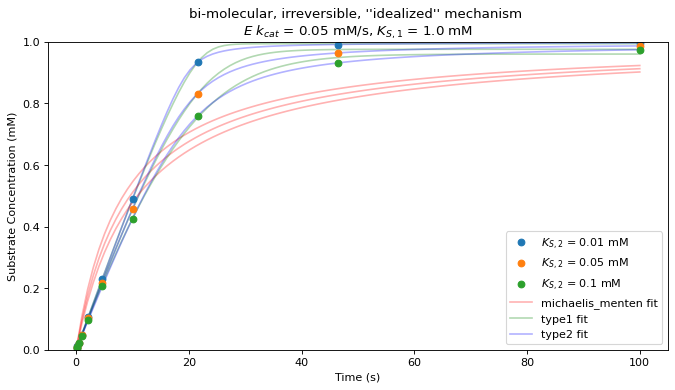

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=80)

E = 1.0  # mM
kcat = 0.05 # 1/s
K_S1 = 1.0 # mM
K_eq = 100.0

t_eval = np.logspace(-1, 2, 10)
t_simulate = np.linspace(0, 100, 100)

for i, K_S2 in enumerate([0.01, 0.05, 0.1]): # mM
  substrate_concentration = simulate_enzyme_assay_bi(t_eval, S_0, E, kcat=kcat, K_S1=K_S1, K_S2=K_S2)
  ax.plot(t_eval, substrate_concentration, 'o', label=f"$K_{{S,2}}$ = {K_S2} mM", zorder=2)
  for form in FORMS:
    popt = fit_analytic(t_eval, substrate_concentration, form=form)
    ax.plot(t_simulate, analytic(form=form)(t_simulate, *popt), color=FORM2COLOR[form], alpha=0.3, zorder=1, label=f"{form} fit" if i == 2 else None)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Substrate Concentration (mM)")
ax.set_title(f"bi-molecular, irreversible, ''idealized'' mechanism \n$E~k_{{cat}}$ = {E*kcat} mM/s, $K_{{S,1}}$ = {K_S1} mM")
ax.legend()
ax.set_ylim(0, 1)


(0.0, 20.0)

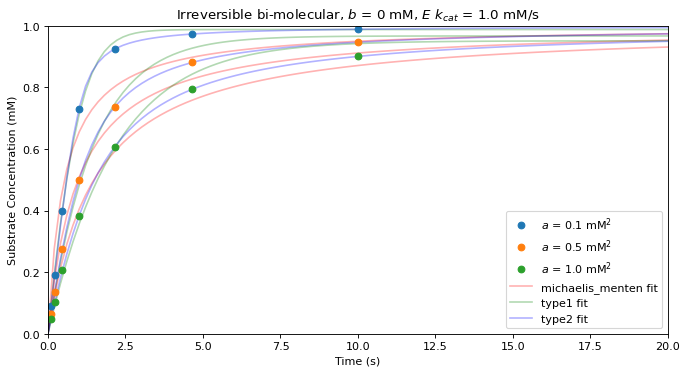

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=80)

E = 1.0  # mM
kcat = 1.0 # 1/s
b = 0

t_eval = np.logspace(-1, 2, 10)
t_simulate = np.linspace(0, 20, 100)
p_simulate = np.linspace(0.001, 0.999, 1000)

for i, a in enumerate([0.1, 0.5, 1.0]): # mM
  substrate_concentration = simulate_enzyme_assay_bi_general(t_eval, S_0, E, kcat=kcat, a=a, b=b)
  ax.plot(t_eval, substrate_concentration, 'o', label=f"$a$ = {a} mM$^2$", zorder=2)
  for form in FORMS:
    popt = fit_analytic(t_eval, substrate_concentration, form=form)
    ax.plot(t_simulate, analytic(form=form)(t_simulate, *popt), color=FORM2COLOR[form], alpha=0.3, zorder=1, label=f"{form} fit" if i == 2 else None)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Substrate Concentration (mM)")
ax.set_title(f"Irreversible bi-molecular, $b$ = 0 mM, $E~k_{{cat}}$ = {E*kcat} mM/s")
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(0, 20)

(0.0, 20.0)

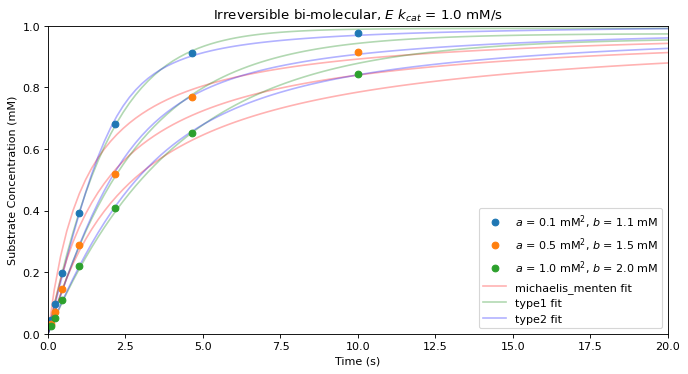

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=80)

K_S1 = 1.0 # mM
E = 1.0  # mM
kcat = 1.0 # 1/s

for i, K_S2 in enumerate([0.1, 0.5, 1.0]): # mM
  a = K_S1 * K_S2
  b = K_S1 + K_S2
  substrate_concentration = simulate_enzyme_assay_bi_general(t_eval, S_0, E, kcat=kcat, a=a, b=b)
  ax.plot(t_eval, substrate_concentration, 'o', label=f"$a$ = {a} mM$^2$, $b$ = {b} mM", zorder=2)
  for form in FORMS:
    popt = fit_analytic(t_eval, substrate_concentration, form=form)
    ax.plot(t_simulate, analytic(form=form)(t_simulate, *popt), color=FORM2COLOR[form], alpha=0.3, zorder=1, label=f"{form} fit" if i == 2 else None)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Substrate Concentration (mM)")
ax.set_title(f"Irreversible bi-molecular, $E~k_{{cat}}$ = {E*kcat} mM/s")
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(0, 20)